In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from DE_library import simulate_ODE, simulate_phase_portrait
import matplotlib.pyplot as plt

import sys
from MARBLE import utils, geometry, net, plotting

rng = np.random.RandomState(1)

Bogdanov-Takens system http://www.scholarpedia.org/article/Bogdanov-Takens_bifurcation

# For initial conditions, sample the $[-1,1]^2$ rectangle uniformly

In [2]:
t0, t1, dt = 0, 5, 0.05
t = np.arange(t0, t1, dt)
n = 100

X0_range = [geometry.sample_2d(n, [[-1,-1],[1,1]], 'random') for i in range(4)]

# Display state spaces under four different parameter conditions

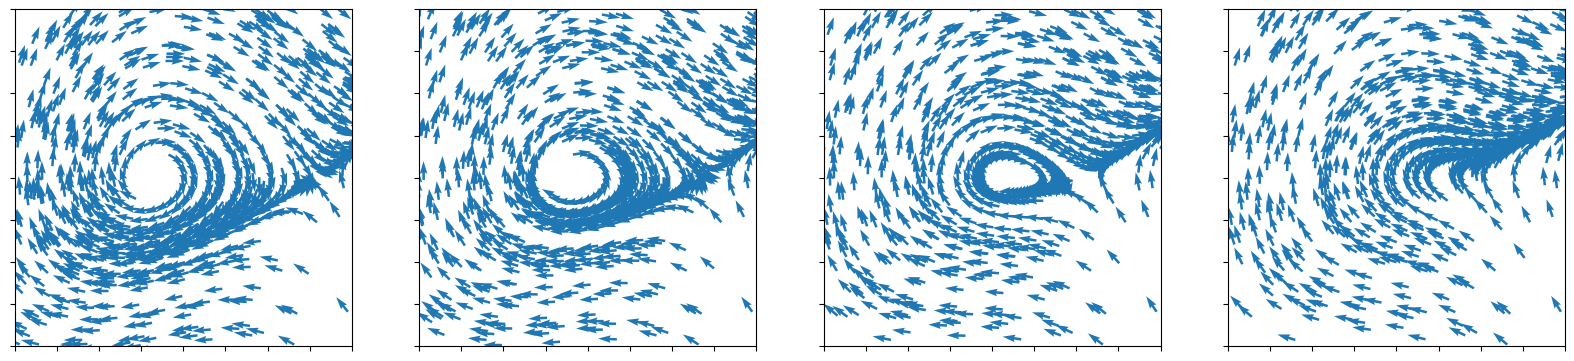

In [3]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

def simulate_system(beta1, X0_range):
    pos, vel = simulate_phase_portrait('bogdanov_takens', t, X0_range, par = {'beta1': beta1, 'beta2': -0.6})
    return pos, vel

def plot_phase_portrait(pos, vel, ax, style='>', arrow_spacing=7):

    for p, v in zip(pos, vel):
        ax = plotting.trajectories(p, v, ax=ax, style=style, lw=1, arrowhead=.03, arrow_spacing=arrow_spacing, axis=False, alpha=None)
    ax.axis('square')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    
pos, vel = simulate_system(-0.15, X0_range[0])
plot_phase_portrait(pos, vel, ax[0])
pos, vel = simulate_system(-0.05, X0_range[1])
plot_phase_portrait(pos, vel, ax[1])
pos, vel = simulate_system(0.05, X0_range[2])
plot_phase_portrait(pos, vel, ax[2])
pos, vel = simulate_system(0.15, X0_range[3])
plot_phase_portrait(pos, vel, ax[3])

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [4]:
beta1 = np.linspace(-.15,.15,20)

pos, vel = [], []
for b1 in beta1:
    X0_range = geometry.sample_2d(n, [[-1,-1],[1,1]], 'random')
    p, v = simulate_system(b1, X0_range)
    pos.append(np.vstack(p))
    vel.append(np.vstack(v))

# Subsample phase portrait

In [5]:
pos_subsample, vel_subsample = [], []
for i, (p,v) in enumerate(zip(pos,vel)):
    ind, _ = geometry.furthest_point_sampling(p, stop_crit=0.0025)
    pos_subsample.append(p[ind])
    vel_subsample.append(v[ind])

Compare phase portraits before and after subsampling

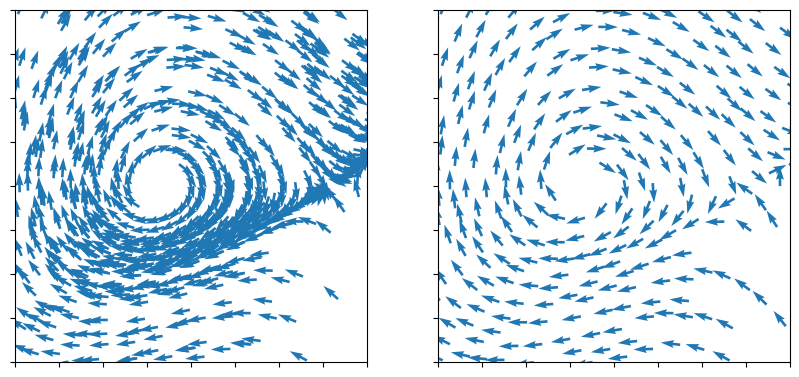

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

plot_phase_portrait([pos[0]], [vel[0]], ax[0], style='>', arrow_spacing=7)
plot_phase_portrait([pos_subsample[0]], [vel_subsample[0]], ax[1], style='>', arrow_spacing=1)

# Train network

In [64]:
k=10

ind = rng.permutation(len(beta1))
pos_subsample = [pos_subsample[i] for i in ind]
vel_subsample = [vel_subsample[i] for i in ind]

data = utils.construct_dataset(pos_subsample, features=vel_subsample, graph_type='cknn', k=k)

In [65]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

par = {'batch_size': 256, #batch size, this should be as large as possible
       'epochs': 30, #optimisation epochs
       'order': 2, #order of derivatives
       'depth': 0, #number of hops in neighbourhood
       'n_lin_layers': 2,
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 4,
       'diffusion': False,
       'inner_product_features': False
      }

model = net(data, gauge='global', **par)
model.run_training(data)


---- Embedding dimension: 2
---- Manifold dimension: 2 

---- Settings: 

gauge : global
batch_size : 256
epochs : 30
order : 2
depth : 0
n_lin_layers : 2
hidden_channels : 16
out_channels : 4
diffusion : False
inner_product_features : False
vector : False
frac_geodesic_nb : 2.0
var_explained : 0.9
frac_sampled_nb : 0.8
dropout : 0.0
bias : False
batch_norm : batch_norm
lr : 0.01
seed : 0
signal_dim : 2
emb_dim : 2
n_sampled_nb : 8
n_geodesic_nb : 20


---- Number of features to pass to the MLP:  14
---- Total number of parameters:  377

---- Starting training ... 

Epoch: 1, Training loss: 38.0437, Validation loss: 36.3802
Epoch: 2, Training loss: 36.2812, Validation loss: 36.0361
Epoch: 3, Training loss: 35.3114, Validation loss: 35.7965
Epoch: 4, Training loss: 35.5380, Validation loss: 35.1174
Epoch: 5, Training loss: 35.2576, Validation loss: 36.5739
Epoch: 6, Training loss: 34.5920, Validation loss: 34.6520
Epoch: 7, Training loss: 34.2615, Validation loss: 34.2966
Epoch: 8, Tra

# Create embeddings and cluster

In [66]:
n_clusters = 20

data = model.evaluate(data)
emb, clusters, dist = geometry.cluster_embedding(data, n_clusters=n_clusters)

Performed t-SNE embedding on embedded results.


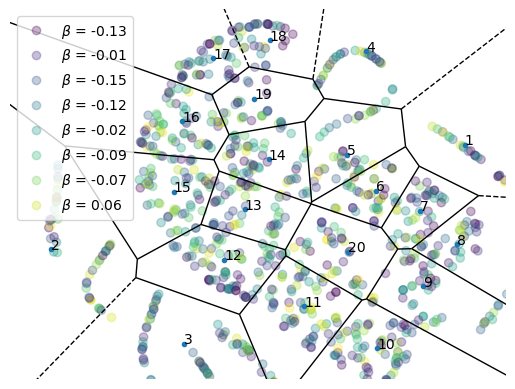

In [67]:
titles = [r'$\beta$ = {:0.2f}'.format(b) for b in beta1[ind]]
plotting.embedding(emb, data.y.numpy(), clusters, titles=titles)#, save='scalar_fields_embedding.svg') 

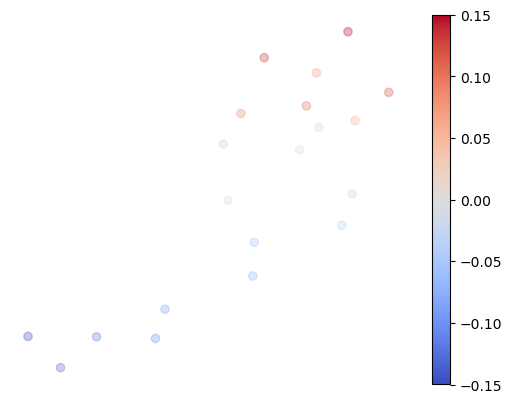

In [68]:
emb_MDS = geometry.embed(dist, embed_typ='MDS')
plotting.embedding(emb_MDS, beta1[ind])

In [22]:
#plotting.neighbourhoods(data, clusters, hops=1)